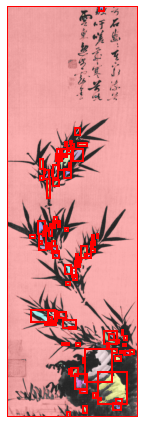

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data, io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


#image = data.coins()[50:-50, 50:-50]
image = rgb2gray(io.imread("test-painting.png"))
#grayplot = plt.imshow(image)

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))
#bwplot = plt.imshow(bw)

# remove artifacts connected to image border
#cleared = clear_border(bw)
#clearplot = plt.imshow(cleared)


# label image regions
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

Some other segmentation approaches:
https://www.learnopencv.com/deep-learning-based-object-detection-and-instance-segmentation-using-mask-r-cnn-in-opencv-python-c/
https://github.com/opencv/opencv/blob/master/samples/dnn/segmentation.py

But first try to use the nice built-in HFS techniques for segmentation. Those last results were crappy.

total blobs: 27
used contour count: 33


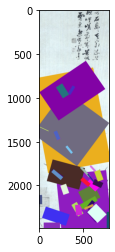

In [3]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("test-painting.png")

# create engine
engine = cv2.hfs.HfsSegment_create(img.shape[0], img.shape[1])
engine.setSlicSpixelSize(50)
# perform segmentation
# now "res" is a matrix of indices
# change the second parameter to "True" to get a rgb image for "res"
res = engine.performSegmentCpu(img, False)
num_blobs = np.max(res)
print("total blobs:", num_blobs)

"""res_w = res.shape[1]
res_h = res.shape[0]
masks = {}
for x in range(1, res_h-1):
    for y in range(1, res_w-1):
        idx = res[x][y]
        if not(idx in masks):
            masks[idx] = np.zeros(res.shape, np.uint8)
        masks[idx][x][y] = 255

print("blobs: ", len(masks.items()))
"""

contours = []
for idx in range(1, num_blobs+1):
    mask = cv2.compare(res, idx, cv2.CMP_EQ)
    mask = cv2.dilate(mask, None)
    mask = cv2.erode(mask, None)
    t_contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours += t_contours

#contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

cont_count = 0
for cont in cont_sorted[1:]:  
    epsilon = 0.005*cv2.arcLength(cont, True)
    c_smooth = cv2.approxPolyDP(cont, epsilon, True)
    area = cv2.contourArea(c_smooth)
    center, dim, theta = cv2.minAreaRect(cont)
    w = dim[0]
    h = dim[1]
    
    if area < 100:
        continue
        
    # print("contour W x H:",w,h,"center", center, "theta", theta)

    if w > h:
        ratio = float(w)/h
        theta = theta - 90
    else:
        ratio = float(h)/w

    if (dim[0] > 100) or (dim[1] > 100):
        col = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        box = cv2.boxPoints(cv2.minAreaRect(cont))
        box = np.intp(box)
        #img = cv2.drawContours(img, [box], 0, (255, 0, 0))
        img = cv2.fillPoly(img, [box], col)
        cont_count +=1
        #img = cv2.rectangle(img, cv2.minAreaRect(cont), (255, 0, 0))

print("used contour count:", cont_count)

plt.imshow(img)
plt.show()

In [111]:
from nltk.corpus import wordnet as wn
import nltk

sample = """
The man bought a new table and chairs for his daughter and aged mother.
He worked in a slaughterhouse pushing a broom and pulling a chain.
"""

artifact = wn.synset('artifact.n.01')
wordlist = []
sents = nltk.sent_tokenize(sample)
for sent in sents:
    wordlist += nltk.word_tokenize(sent)

for word in wordlist:
    stem = wn.morphy(word)
    if not stem:
        continue
    search = True
    for syn in wn.synsets(stem):
        if (syn.pos() == "n") and search:
            if artifact in syn.hypernym_paths()[0]:
                print(stem, "is an artifact!")
                search = False
            

man is an artifact!
table is an artifact!
chair is an artifact!
work is an artifact!
slaughterhouse is an artifact!
broom is an artifact!
chain is an artifact!


In [3]:
import urllib.request
import cssselect
import lxml.html

headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0'}
selector = cssselect.HTMLTranslator().css_to_xpath("img.s-image")
req = urllib.request.Request('https://www.amazon.com/s?k=fork', None, headers)
with urllib.request.urlopen(req) as response:
    html = response.read()
    document = lxml.html.fromstring(html)
    element_list = document.xpath(selector)
    print(len(element_list), "images available for this query")
    element = element_list[0]
    img_url = element.get("src")
    print(element.get("src"))

48 images available for this query
https://m.media-amazon.com/images/I/51KpGEAv8aL._AC_UL320_ML3_.jpg


now remove the background and cut out the minimum rect of the shape

Note: it might be wise to add about 10px of white around the edge of the image

In [4]:

import requests

BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0,0.0,1.0) # In BGR format

saved_img = img_url.rsplit('/',1)[1]
saved_img = "/tmp/" + saved_img
resp = requests.get(img_url, headers=headers, allow_redirects=True)
open(saved_img, 'wb').write(resp.content)
img_color = cv2.imread(saved_img)
img_color = cv2.copyMakeBorder(img_color,10,10,10,10,cv2.BORDER_CONSTANT, value=[255, 255, 255])
img_gray = cv2.imread(saved_img, flags=cv2.IMREAD_GRAYSCALE)
img_gray = cv2.copyMakeBorder(img_gray,10,10,10,10,cv2.BORDER_CONSTANT, value=[255])


# most of this is ganked directly from this https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image

#-- Edge detection -------------------------------------------------------------------
edges = cv2.Canny(img_gray, CANNY_THRESH_1, CANNY_THRESH_2)
edges = cv2.dilate(edges, None)
edges = cv2.erode(edges, None)

#-- Find contours in edges, sort by area ---------------------------------------------
contour_info = []
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Previously, for a previous version of cv2, this line was: 
#  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Thanks to notes from commenters, I've updated the code but left this note
for c in contours:
    contour_info.append((
        c,
        cv2.isContourConvex(c),
        cv2.contourArea(c),
    ))
contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
max_contour = contour_info[0]


#-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
# Mask is black, polygon is white
mask = np.zeros(edges.shape)
cv2.fillConvexPoly(mask, max_contour[0], (255))

#-- Smooth mask, then blur it --------------------------------------------------------
mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

#-- Blend masked img into MASK_COLOR background --------------------------------------
mask_stack = mask_stack.astype('float32') / 255.0          # Use float matrices, 
img_color = img_color.astype('float32') / 255.0                 #  for easy blending

#masked = (mask_stack * img_color) + ((1-mask_stack) * MASK_COLOR) # Blend
#masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

# split image into channels
c_red, c_green, c_blue = cv2.split(img_color)

# merge with mask got on one of a previous steps
img_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))


# find bounding minimum bounding rect as that's what we want to rotate & save
rect = cv2.minAreaRect(max_contour[0])
(h, w) = rect[1]
h = round(h)
w = round(w)
angle = rect[2]

box = cv2.boxPoints(rect)
box = np.int0(box)
#img_a = cv2.drawContours(img_a,[box],0,(0,0,255, 255),2)
#cv2.imwrite("/tmp/test_uncropped.png", img_a*255)

# find angle if positive, otherwise, just take the inverse of the angle to make
if angle < -45:
    angle = (90 + angle)
else:
    angle = -angle  


width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(img_a, M, (width, height))


# save to disk
cv2.imwrite('/tmp/test_alpha.png', warped*255)

plt.imshow(warped)
plt.show()


NameError: name 'img_url' is not defined

Try the same background subtraction on the leave scans

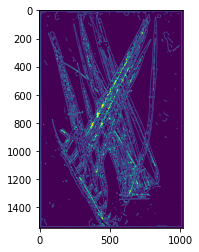

total area: 1576920
contour area: 229380.5
ratio: 0.1454610887045633


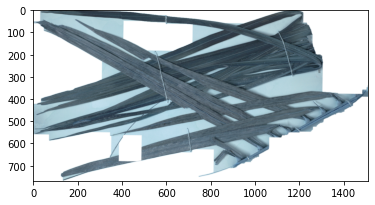

In [124]:
BLUR = 3
CANNY_THRESH_1 = 200
CANNY_THRESH_2 = 250
MASK_DILATE_ITER = 40
MASK_ERODE_ITER = 40
MASK_COLOR = (0.0,0.0,1.0) # In BGR format


def test_bg_sub(test_img):
    img_color = cv2.imread(test_img)
    img_color = cv2.copyMakeBorder(img_color,10,10,10,10,cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img_gray = cv2.imread(test_img, flags=cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.copyMakeBorder(img_gray,10,10,10,10,cv2.BORDER_CONSTANT, value=[255])
    aperture = 5  # default is 3 but 5 or 7 are more sensitive

    blurred = cv2.GaussianBlur(img_gray, (9, 9), 0)


    # most of this is ganked directly from this https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(blurred, CANNY_THRESH_1, CANNY_THRESH_2, apertureSize=aperture, L2gradient=False)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    plt.imshow(edges)
    plt.show()

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    
    # filter out the accidental box contours - should be less than 85% of pixels
    img_area = img_color.shape[0] * img_color.shape[1]
    for cont in contour_info:
        max_contour = cont
        pixel_ratio = max_contour[2] / img_area
        if pixel_ratio < 0.85:
            break
    
    print("total area:", img_area )
    print("contour area:", max_contour[2])
    print("ratio:", max_contour[2] / img_area) 


    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img_color = img_color.astype('float32') / 255.0                 #  for easy blending

    #masked = (mask_stack * img_color) + ((1-mask_stack) * MASK_COLOR) # Blend
    #masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    # split image into channels
    c_red, c_green, c_blue = cv2.split(img_color)

    # merge with mask got on one of a previous steps
    img_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))


    # find bounding minimum bounding rect as that's what we want to rotate & save
    rect = cv2.minAreaRect(max_contour[0])
    (h, w) = rect[1]
    h = round(h)
    w = round(w)
    angle = rect[2]

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #img_a = cv2.drawContours(img_a,[box],0,(0,0,255, 255),2)
    #cv2.imwrite("/tmp/test_uncropped.png", img_a*255)

    # find angle if positive, otherwise, just take the inverse of the angle to turn
    if angle < -45:
        angle = (90 + angle)
    else:
        angle = -angle  


    width = int(rect[1][0])
    height = int(rect[1][1])

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img_a, M, (width, height))
    
    plt.imshow(warped)
    plt.show()
    
#test_bg_sub("test-leaves/cinchona_officinalis.jpg")
#test_bg_sub("test-leaves/drymis_winteri_brasil_1840.jpg")
#test_bg_sub("test-leaves/Elaeis guineensis_oil_palm_congo_1900.jpg")
test_bg_sub("test-leaves/cleaned1.jpg")
#test_bg_sub("test-leaves/juglans_nigra_black_walnut_kenya.jpg")
#test_bg_sub("test-leaves/passiflora_ligularis_zimbabwe.jpg")
